# ML-5 Валидация данный и оценка моделей
###  Содержание <a class="anchor" id=0></a>
- [1. Введение](#1)
- [2. Валидация данных. Методы валидации](#2)
- [2.1 hold-out (отложенная выборка)](#2-1)
- [2.2 k-fold (кросс валидация)](#2-2)
- [2.3 leave-one-out (отложенный пример)](#2-3)
- [3. Дисбаланс выборки](#3)
- [4. Недообучение и переобучение. Утечка данных](#4)
- [5. Кривая обучения](#5)
- [6. Практика](#6)
- [7. Итоги](#7)


2. # Валидация данных. Методы валидации <a class="anchor" id=2></a>

[к содержанию](#0)

**Главная цель машинного обучения** — усвоить общие закономерности в данных, а не просто запомнить обучающий, или тренировочный, набор данных (training data).

Поэтому так важно иметь отложенный набор данных (с известными правильными ответами), который модель не видела во время обучения. На нём мы будем оценивать качество обученной модели.

>В предыдущих модулях по машинному обучению тот набор данных, на котором мы проверяли качество построенной модели, мы называли тестовым набором данных (`testing data`). Мы заранее выделяли этот набор данных для того, чтобы рассчитать финальную метрику модели и сделать вывод о том, устраивает ли нас качество моделирования. Такой подход называется `двухкомпонентным`.

<img src=ml5_img1.png width=400>

>**Примечание**. Ранее мы использовали тестовый набор не только для проверки итогового качества, но и для подбора внешних параметров. Вспомните: мы выбирали оптимальные пороги вероятности и коэффициенты регуляризации, при которых наблюдался максимум целевой метрики (мы использовали `F1`-меру). 
>
>Однако такой подход не совсем корректен, ведь мы подстраивали модель под тестовую выборку, то есть по сути занимались небольшим самообманом. Тестовая выборка должна быть «независимым судьёй», который должен объективно и непредвзято «выносить приговор» нашей модели.

Из-за этого в больших Data Science-проектах используется не два, а три набора данных: в дополнение к тренировочному и тестовому набору данных выделяется **валидационный набор** (`validation data`). Этот набор используется для промежуточного контроля качества модели и настройки внешних параметров, которые задаёт исследователь при построении модели. Такой подход называется трёхкомпонентным.

<img src=ml5_img2.jpg width=400>

## Итак, существует три основных вида выборок, которые используются в машинном обучении:

1. **Обучающая (тренировочная)** — набор данных, который используется в процессе обучения модели (подбора внутренних параметров, например коэффициентов линейной регрессии или предикатов в деревьях решений).

2. **Валидационная (проверочная)** — набор данных, на котором мы оцениваем промежуточные результаты обучения.

Основная цель создания такого набора данных — отслеживание переобучения.

На валидационной выборке мы производим подбор гиперпараметров — внешних параметров модели, например коэффициентов регуляризации, максимальной глубины дерева, количества деревьев в случайном лесу и т. д.

3. **Тестовая (контрольная)** — набор данных, который имитирует работу модели в реальных условиях после подбора всех параметров.

С помощью этого набора осуществляется окончательная проверка качества.

Главное условие для тестовой выборки — она должна быть независимой от обучающей.

> ## ОСОБЕННОСТИ ТЕРМИНОЛОГИИ
>
>В промышленности, научных кругах и различной литературе термины **валидационная** и **тестовая выборка** зачастую употребляются как синонимы. Строго говоря, они не являются таковыми.
>
>**Тестирование** — это попытка что-то выяснить, а **валидация** — доказать, что что-то является истиной (в нашем случае — доказать, что качество модели на валидационной выборке совпадает с качеством при обучении).
>
>Вне зависимости от того, как будут называться контрольные выборки, важная концепция, которую необходимо сохранить, состоит в том, что окончательный набор (называемый тестом или валидацией) не используется в процессе обучения модели, а используется исключительно для оценки её качества.

Процесс проверки предсказательной способности модели машинного обучения называется `валидацией`.

Существует несколько методов такого контроля. Мы последовательно рассмотрим каждый из них.

Но прежде чем мы перейдём к обсуждению методов валидации, давайте познакомимся с данными, на которых будем практиковаться

В этом модуле мы будем решать задачу классификации: классифицировать воду на пригодную  и не пригодную для питья на основе её химического состава.

Скачать набор данных можно [здесь](https://lms.skillfactory.ru/assets/courseware/v1/9cd645af21ef409ff23bf03a783b4b71/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/water_potability.zip). С подробным описанием датасета и столбцов таблицы ознакомьтесь [в источнике](https://www.kaggle.com/datasets/adityakadiwal/water-potability).

Переходим к работе с данными. Импортируем модули, которые нам понадобятся:

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
plt.style.use('seaborn') #стиль отрисовки seaborn
%matplotlib inline

In [2]:
water_data = pd.read_csv('water_potability.zip')
water_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


Невооруженным глазом видно, что большинство столбцов таблицы являются числовыми. Целевой признак — `Potability` (пригодность для питья): `1` — вода пригодна, `0` — вода не пригодна.

В данных есть пропуски. Выведем информацию о них в процентном соотношении:

In [3]:
display(water_data.isnull().mean() * 100)

ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64

Итак, у нас отсутствует около `15 %` информации о кислотности воды (`ph`), около` 24 %` — о содержании сульфатов (`Sulfate`) и около `5 %` — о тригалометанах (`Trihalomethanes`). Мы знаем, что пропуски — непосильная ноша для большинства моделей машинного обучения. Их необходимо обработать.

Заполним пропуски медианным значением в признаке зависимости класса воды (`Potability`). Для этого сгруппируем данные по признаку `Potability`, посчитаем медиану в каждой группе, а затем отправим результат в метод `fillna()`:

In [4]:
#Заполняем пропуски
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

display(water_data.isnull().mean() * 100)

ph                 0.0
Hardness           0.0
Solids             0.0
Chloramines        0.0
Sulfate            0.0
Conductivity       0.0
Organic_carbon     0.0
Trihalomethanes    0.0
Turbidity          0.0
Potability         0.0
dtype: float64

Теперь проблема пропусков устранена. Давайте по традиции разделим набор данных на матрицу наблюдений `X` и вектор правильных ответов `y`:

In [5]:
X = water_data.drop('Potability', axis=1)
y = water_data['Potability']

# HOLD-OUT <a class="anchor" id=2-1></a>

[к содержанию](#0)

Метод `hold-out` (отложенная выборка) нам уже знаком. Это самый простой и очень популярный метод.

Его идея состоит в том, что для проверки модели мы просто случайным образом разбиваем весь набор данных на обучающую, валидационную и тестовую выборки (последняя — по желанию).

Обычно разбиение производится в соотношении `70/30` или `80/20` при двухкомпонентном подходе, и в соотношении `70/15/15` или `80/10/10` — при трёхкомпонентном.

Схема разбиения представлена ниже:

<img src=ml5_img3.png>

## Плюсы:

* Очень простой и понятный.

* Чаще всего применяется на больших датасетов, так как требует значительно меньше вычислительных мощностей, чем другие методы.

## Минусы:

* Важно помнить, что разбиение производится случайным образом и оценка в этом методе зависит от того, какие наблюдения попали в набор для валидации. Это плохо, так как возможна ситуация, когда распределение целевого признака в тренировочной, валидационной (и тестовой) выборках может значительно различаться и оценка качества может быть необъективной.

## РЕАЛИЗАЦИЯ МЕТОДА В `SKLEARN`

Все методы разбиения выборки и валидации, которые мы будем изучать, находятся в модуле `model_selection`, мы импортировали его заранее.

Метод hold-out реализован в уже знакомой вам функции [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Она предназначена для разбиения исходного набора данных случайным образом на две части в заданных соотношениях.

>Основные параметры `train_test_split()`:
>
>* `*arrays` — порядковый аргумент с переменным количеством. Набор массивов (это могут быть списки, numpy-массивы, DataFrame), которые подлежат разбиению.
>* `test_size` — размер тестовой (валидационной) выборки. Может быть указан в долях. Определяется автоматически, если параметр `test_size` передан как `1-train_size`.
>* `train_size` — размер тренировочной выборки. Может быть указан в долях. Определяется автоматически, если параметр `test_size` передан как `1-test_size`.
>* `random_state` — число, на основе которого производится генерация случайных чисел.
>* `shuffle` — параметр, указывающий, стоит ли перемешивать выборку перед разбиением (по умолчанию `True`).
>* `stratify` — стратифицированное разбиение (о нём мы поговорим в юните по дисбалансу выборки).

Если мы используем двухкомпонентный подход (разбиваем выборку на тренировочную и валидационную, она же тестовая), то всё очень просто: нам лишь нужно вызвать функцию `train_test_split()` и передать в неё матрицу наблюдений `X` и вектор-столбец с правильными ответами `y`.

Для примера разделим выборку в соотношении `80/20` (`test_size=0.2`), в качестве значения параметра `random_state` по традиции возьмём число `42`.

Функция вернёт четыре массива:

* таблицу `X` с обучающими примерами,
* таблицу `X` с примерами для валидации,
* столбец `y` с ответами на обучающие примеры,
* столбец `y` с ответами на валидационные примеры.

In [6]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (2620, 9)
Valid shape: (656, 9)


Итак, `2 620` образцов воды являются обучающими — в них модель будет искать закономерности и подбирать внутренние параметры, а `656` являются валидационными — на них мы будем производить контроль качества.

Далее нам останется только обучить модель на тренировочной выборке (`X_train`, `y_train`) и рассчитать метрики на валидационной выборке (`X_valid`, `y_valid`).

В качестве модели будем использовать дерево решений с максимальной глубиной `7`, `энтропией` в качестве критерия информативности, минимальное число объектов в листе дерева — `5`.

После обучения сделаем предсказание для каждой из выборок и рассчитаем метрику. В качестве метрики для простоты возьмём долю правильных ответов — `accuracy`.

In [7]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print('Train hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Valid hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred))) 

Train hold-out accuracy: 0.82
Valid hold-out accuracy: 0.77


Если же мы используем `трёхкомпонентный` подход (разбиваем выборку на тренировочную, валидационную и отдельную тестовую), тут нам понадобится чуть больше кода. К сожалению, в `sklearn` нет специализированного функционала для такого разбиения.

Применим функцию `train_test_split()` дважды: сначала разобьём исходный набор на тренировочный и валидационный в соотношении `80/20`, затем разобьём валидационный набор на валидационный и тестовый в соотношении `50/50`. В итоге наша выборка будет разбита в соотношении `80/10/10`:

In [8]:
#разбиваем исходную выборку на тренировочную и валидационную в соотношении 80/20
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
#разбиваем валидационную выборку на валидационную и тестовую в соотношении 50/50
X_valid, X_test, y_valid, y_test = model_selection.train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

# K-FOLD <a class="anchor" id=2-2></a>

[к содержанию](#0)

>Метод `k-fold` более известен как `кросс-валидация` (`cross validation`), или перекрёстный контроль.

Пожалуй, это самый **популярный метод валидации** для оценки качества моделирования, и он используется практически во всех проектах. Эта идея также применяется во многих моделях и методах машинного обучения, например в стекинге.

Напомним алгоритм кросс-валидации:

1. Разбить исходную выборку на `k` частей — **фолдов (fold)**.

2. Повторять `k` раз:
* Обучить модель на `k-1` частях. Назовём их тренировочными фолдами (`training fold`). 
* Произвести оценку качества (вычислить метрику) на оставшейся части. Назовем её валидационным фолдом (`validation fold`).

3. Усреднить значения метрики на валидационных фолдах.


Схематично алгоритм кросс-валидации можно представить следующим образом (на рисунке представлена схема работы кросс-валидации с предварительно выделенной для тестирования выборкой):

<img src=ml5_img4.png>

Благодаря такому подходу мы избавляемся от необходимости создавать отложенную валидационную выборку — мы генерируем её искусственно на каждом из этапов кросс-валидации из исходного набора данных. Каждая из `k` частей исходного обучающего набора данных используется в качестве валидационной выборки.

Для больших наборов данных в качестве значения `k` часто берут `10`, то есть выборка разбивается на десять фолдов. В случае маленьких выборок `k` берут равным `3 или 5`.

>Чем больше `k`, тем больше моделей будут обучаться, тем объективнее будет оценка качества, однако тем больше времени займёт процесс валидации.

## Плюсы:

* Подход позволяет получить более устойчивую к выбросам оценку качества модели, так как модель обучается на нескольких независимых наборах данных.

* Значения метрик получаются более объективными, ведь мы обучаем одну модель `k` раз — у нас получается `k` независимых друг от друга значений метрики.

>**Примечание**. Мы оцениваем метрику не по одному значению на валидационной выборке, как это было в `hold-out`, а по `k` значений. Если `k` достаточно велико, можно даже построить гистограмму и оценить, в каких пределах находится истинное качество. Однако на практике этим занимаются крайне редко, так как такие вычисления очень времязатратны.

## Минусы:

* Подход предусматривает, что мы обучаем одну и ту же модель `k` раз, что, очевидно, плохо сказывается на производительности. Если модель обучается довольно медленно (например, сложная нейронная сеть), то валидация может занять очень много времени.

# РЕАЛИЗАЦИЯ МЕТОДА В SKLEARN

В библиотеке `sklearn` метод `k-fold` реализован в классе `KFold`.

>Основные параметры инициализатора `KFold`:
>
>* `n_split` —  число фолдов (число  из метода `k-fold`). По умолчанию — `5`.
>* `shuffle` — параметр, указывающий, стоит ли перемешивать исходный набор данных перед разбиением. По умолчанию — `False`.
>* `random_state` — число, на основе которого производится генерация случайных чисел, если набор данных будет перемешиваться.

У объекта класса `KFold` есть метод `split()`. В данный метод необходимо передать матрицу наблюдений `X` и вектор-столбец ответов `y` — метод вернёт генератор, который позволит получать индексы тренировочной и валидационной выборок, сгенерированных по методу `k-fold`.

Будем использовать двухкомпонентный контроль, то есть подавать в кросс-валидацию весь доступный набор данных без предварительного выделения тестовой выборки.

Создадим объект `KFold` для кросс-валидации с пятью фолдами, остальные параметры оставим по умолчанию. Затем организуем цикл `for` для получения элементов из генератора, созданного с помощью метода `split()`. На каждой итерации в переменных `train_index` и `valid_index` будут находиться индексы текущей тренировочной и валидационной выборок соответственно.

>**В цикле будем:**
>
>* выделять строки таблицы, относящиеся к текущим тренировочной и валидационной выборкам, в отдельные таблицы;
>* обучать дерево решений;
>* делать предсказания для текущих тренировочной и валидационной выборок;
>* рассчитывать метрику accuracy на текущих выборках и заносить её значение в список.

Код будет выглядеть следующим образом:

In [9]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
#Создаём список для хранения тренировочных и валидационных метрик
train_metrics = []
val_metrics = []
#Организуем цикл для кросс-валидации (используем весь набор данных)
#train_index — индексы тренировочной выборки
#valid_index — индексы валидационной выборки
for train_index, valid_index in kf.split(X, y): 
    #Создаём тренировочную и валидационную выборку, обращаясь по текущим индексам
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    #Обучаем случайный лес на тренировочной выборке
    model.fit(X_train, y_train)
    #Делаем предсказание для каждой из выборок
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    #Рассчитываем метрику и заносим её в список
    train_metrics.append(metrics.accuracy_score(y_train, y_train_pred))
    val_metrics.append(metrics.accuracy_score(y_valid, y_valid_pred))

In [10]:
print('train_metrics:', train_metrics)
print('val_metrics: ', val_metrics)

train_metrics: [0.8034351145038168, 0.8168637924456315, 0.8027470431133156, 0.8267836703548264, 0.8157191911484166]
val_metrics:  [0.7957317073170732, 0.7053435114503817, 0.7358778625954199, 0.7282442748091603, 0.732824427480916]


В каждом из выведенных списков содержится по пять значений метрики `accuracy`, вычисленных на тренировочном и валидационном фолдах кросс-валидации. Для агрегированной оценки рассчитаем среднее значение метрик:

In [11]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(train_metrics)))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(val_metrics)))

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


Итак, среднее значение метрики `accuracy` на кросс-валидации равно `0.81` для тренировочных фолдов и `0.74` — для валидационных фолдов. Помним о том, что основной показатель для нас — метрика на **валидационных фолдах** (если не предусмотрена тестовая выборка). 

Согласитесь, сложновато — не совсем в стиле `sklearn`. Тут и циклы, и генераторы... Неужели каждый раз придётся писать подобный код для проведения кросс-валидации?

Конечно же, нет. На самом весь приведённый выше код можно значительно сократить, если использовать специальную функцию для кросс-валидации — [cross_validate()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) из модуля `model_selection`. Она организует процедуру кросс-валидации и расчёт метрик.

>Основные параметры функции `cross_validate()`:
>
>* `estimator` — модель, качество которой будет проверяться на кросс-валидации.
>* `X` — матрица наблюдений.
>* `y` — вектор-столбец правильных ответов.
>* `cv` — кросс-валидатор из библиотеки `sklearn` (например, `KFold`) или количество фолдов, на которые необходимо разбить выборку. По умолчанию используется кросс-валидация на пяти фолдах.
>* `scoring` — название метрики в виде строки либо функция для её вычисления ('`accuracy`', '`precision`', '`recall`', '`f1`' и другие; полный список — в документации к функции).
>* `return_train_score` — параметр, указывающий стоит ли возвращать значения метрики, полученных на тренировочных фолдах. По умолчанию — `False`, то есть метрики считаются только на валидационных фолдах.

Функция возвращает словарь со следующими ключами:

* `fit_time` — время обучения модели на каждой итерации кросс-валидации;
* `score_time` — время вычисления метрик на каждой итерации кросс-валидации;
* `test_score` — значения метрик на валидационных фолдах;
* `train_score` — значения метрик на тренировочных фолдах.

Итоговый код с использованием функции `cross_validate()` будет выглядеть следующим образом:

In [12]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=kf, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.02094316, 0.0229702 , 0.01894951, 0.01892042, 0.01894927]),
 'score_time': array([0.00199628, 0.00199175, 0.00199676, 0.00103331, 0.00099564]),
 'test_score': array([0.79573171, 0.70534351, 0.73587786, 0.72824427, 0.73282443]),
 'train_score': array([0.80343511, 0.81686379, 0.80274704, 0.82678367, 0.81571919])}

В массивах, хранящихся по ключам `train_score` и `test_score`, содержится по пять значений метрики accuracy, полученных на тренировочных и валидационных фолдах соответственно на каждой итерации кросс-валидации. Давайте рассчитаем среднее и сравним его с результатом, полученным ранее:

In [13]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


# LEAVE-ONE-OUT <a class="anchor" id=2-3></a>

[к содержанию](#0)

>Метод `leave-one-out` (отложенный пример), или поэлементная кросс-валидация — это частный случай кросс-валидации (`k-fold`), когда размер `k` равняется размеру всей выборки `k = n`, где `n` — количество примеров (строк в таблице).

Алгоритм метода:

1. Повторять  `n` раз:
 * Выбрать один случайный пример для валидации.
 * Обучить модель на всех оставшихся `n-1` примерах.
 * Произвести оценку качества (вычислить метрику) на отложенном примере.

2. Усреднить значение метрик на всех примерах.

<img src=ml5_img5.png>

## Плюсы:

* Идеально подходит для небольших датасетов (**менее 100 примеров**).

* Поскольку все доступные данные используются как для обучения, так и для валидации, значения метрик наиболее объективны и надёжны.

## Минусы:

* Подход предусматривает, что мы обучаем одну и ту же модель `n` раз. Очевидно, что чем больше примеров в обучающем наборе данных, тем больше моделей мы будем обучать. Поэтому метод не подходит для оценки качества модели на больших наборах данных, поскольку становится **очень ресурсозатратным**.
>**Примечание**. Тем не менее, в некоторых методах обучения вычисление leave-one-out получается заметно ускорить, и его использование становится возможным.

# РЕАЛИЗАЦИЯ МЕТОДА В `SKLEARN`

В библиотеке `sklearn` метод `leave-one-out` реализован в классе `LeaveOneOut`. Параметров инициализации у данного класса нет.

Работа с кросс-валидатором полностью идентична работе с `KFold`, который мы рассматривали ранее (цикл для организации кросс-валидации вручную будет выглядеть аналогично).

Объект класса `LeaveOneOut` также можно передать в функцию `cross_validate()` для получения метрик на каждом из примеров. В случае с метрикой `accuracy` список будет состоять из 0 и 1 (0 — модель не угадала класс на отложенном примере, 1 — модель угадала класс на отложенном примере).

Так как датасет у нас довольно большой (более трёх тысяч образцов воды), алгоритм кросс-валидации `leave-one-out` будет выполняться очень долго. Для экономии времени выполнения кода будем использовать первые `500` наблюдений из исходной таблицы.

>**Примечание**. Значение метрики будет рассчитано не для всего набора данных, а только для его части. Если вы захотите рассчитать метрику на всём наборе данных, вместо среза передавайте в функцию таблицу `X` и столбец `y` целиком. Но имейте в виду, что код в таком случае может выполняться до нескольких минут.

Итоговый код:

In [14]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём кросс-валидатор LeaveOneOut
loo = model_selection.LeaveOneOut()
 
#Считаем метрики на кросс-валидации leave-one-out
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X.iloc[:500], #матрица наблюдений X
    y=y.iloc[:500], #вектор ответов y
    cv=loo, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 0.95
Valid k-fold mean accuracy: 0.90


>**Примечание**. Метод `leave-one-out` можно реализовать и без использования специального класса — достаточно просто указать параметр `n_split=n` в инициализаторе `KFold`, где `n` — количество строк в таблице.

<img src=ml5_img6.png>

3. # Дисбаланс выборки <a class="anchor" id=3></a>

[к содержанию](#0)

Несбалансированный набор данных (`unbalanced dataset`) — это выборка, в которой количества примеров каждого из классов значительно отличаются.

При этом:

* класс большинства называется мажоритарным (`majority`) классом;

* класс меньшинства называется миноритарным (`minority`) классом.

<img src=ml5_img7.png width=600>

Данное определение дисбаланса очевидно относится к задаче классификации. Понятие дисбаланса есть и в задачах регрессии, но там оно граничит [с задачей поиска аномалий в данных (Anomaly Detection)](https://dyakonov.org/2017/04/19/поиск-аномалий-anomaly-detection/), которая не входит в рамки нашего курса, поэтому мы будем рассматривать только задачи классификации (для простоты — бинарной классификации).

Типичные примеры задач, в которых исследователи чаще всего сталкиваются с дисбалансом выборки: 

* **Обнаружение мошенничества**. Подавляющие большинство (около 90-99 %) транзакций являются немошенническими, а зафиксированных примеров мошенничества — 1-10 %.

* **Обнаружение оттока клиентов**. Подобную задачу мы уже решали в модуле по классификации. Как правило, отток составляет около 10-30 % против 90-70 % лояльных клиентов.

* **Распознавание лиц**. В базе данных лиц вполне стандартной является ситуация, когда в распоряжении может быть 1 000 примеров фотографий первого человека против 2-3 фотографий второго. Легко понять, что опознать второго человека по фотографии будет намного сложнее, чем первого.

>Проблемы, которые могут возникнуть из-за несбалансированной выборки:
>
>* При разбиении несбалансированной выборки на тренировочную/валидационную/тестовую увеличивается шанс попадания в одну из них объектов только одного класса, из-за чего оценка качества модели может быть необъективной.
>
>* Нельзя использовать метрики, не учитывающие размеры классов, такие как accuracy. Данную проблему мы обсуждали, когда знакомились с метриками классификации.
Стандартные методы ML, такие как дерево решений и логистическая регрессия, имеют тенденцию игнорировать класс меньшинства.

Рассмотрим влияние дисбаланса на примере датасета о качестве воды. Посмотрим на соотношения классов внутри датасета:

0    0.60989
1    0.39011
Name: Potability, dtype: float64

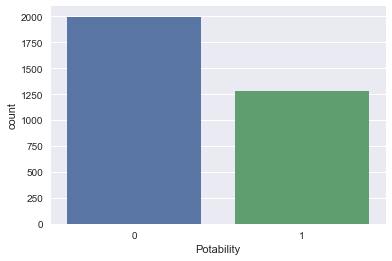

In [15]:
display(water_data['Potability'].value_counts(normalize=True))
sns.countplot(data=water_data, x='Potability');

Итак, `около 61 %` образцов воды являются непригодными для питья и `39 % являются пригодными`. На самом деле это небольшой дисбаланс классов (`61/39`). В реальных задачах мы можете столкнуться и с куда более неравномерными соотношениями, например `80/20`, `90/10` или даже `99/1`. Как работать с такими данными, обсудим далее.

## СТРАТИФИЦИРОВАННОЕ РАЗБИЕНИЕ

>Для того чтобы снизить влияние дисбаланса классов при разбиении выборки, в наборе данных используется специальный тип разбиения, который называется **стратифицированным** (`stratified`). Данное разбиение предполагает, что наблюдения, принадлежащие каждому из классов, гарантированно попадут в каждый из наборов данных в одинаковой пропорции.

Давайте на на примере рассмотрим, как производить стратифицированное разбиение. Начнём с простого разделения `hold-out`, которое мы проводим с помощью функции `train_test_split()`. Для начала проведём обычное случайное разбиение на тренировочную и валидационную выборку (в соотношении `80/20`) без стратификации:

In [16]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
0    0.620229
1    0.379771
Name: Potability, dtype: float64
Valid:
0    0.568598
1    0.431402
Name: Potability, dtype: float64


Мы видим, что соотношения классов в тренировочной выборке — `62/38`, а в тестовой — `57/43`. Давайте попробуем сбалансировать соотношения.

Для стратифицированного разбиения достаточно в функции `train_test_split()` задать параметр `stratify`, в который нужно передать столбец с метками классов, на основе которого будет производиться балансировка. Это будет столбец с правильными ответами `y`.

In [17]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
0    0.609924
1    0.390076
Name: Potability, dtype: float64
Valid:
0    0.609756
1    0.390244
Name: Potability, dtype: float64


Теперь в каждом из наборов данных одинаковые соотношения классов — `61/39`. Метрики, полученные при одинаковых соотношениях на выборках, будут более объективными.

А что насчёт кросс-валидации? Как организовать разбиение по методу `k-fold` и получить одинаковые соотношения классов?

Для этого вместо `KFold` используется кросс-валидатор `StratifiedKFold`. Принцип работы с ним аналогичен, только, в отличие от `KFold`, `StratifiedKFold` будет разбивать выборку на части таким образом, чтобы в тренировочных и валидационных фолдах соотношения классов были приблизительно одинаковыми.

Давайте напишем код, который организует стратифицированное `k-fold`-разбиение на три фолда, и выведем соотношения классов в каждой из выборок:

In [18]:
skf = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_index, valid_index in skf.split(X, y): 
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    print('Train:\n', y_train.value_counts(normalize=True), sep='')
    print('Valid:\n', y_valid.value_counts(normalize=True), sep='')
    print('-'*40)

Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------


Видно, что соотношения классов в тренировочной и валидационной выборках в каждом разбиении примерно одинаковы — `61/39.`

Так же, как и другие кросс-валидаторы, объект класса `StratifiedKFold` может быть использован в функции `cross_validate()`.

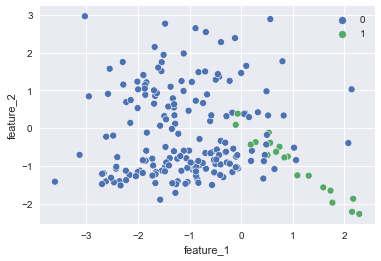

In [19]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=200, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=40 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y);

Разбейте исходный набор данных на тренировочный и валидационный со стратификацией по классам в соотношении `80/20`. В качестве значения параметра `random_state` возьмите число `42`.

Постройте диаграммы рассеяния с цветовой группировкой по классам для валидационной выборки.

Из приведённых ниже диаграмм выберите ту, которая соответствует полученному разбиению:

Train:
0    0.9
1    0.1
dtype: float64
Valid:
0    0.9
1    0.1
dtype: float64


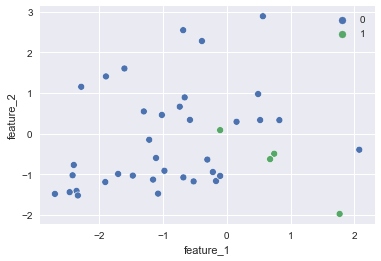

In [20]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')
sns.scatterplot(x=X_valid['feature_1'], y=X_valid['feature_2'], hue=y);

# ВЫБОР МЕТРИК В УСЛОВИЯХ ДИСБАЛАНСА КЛАССОВ

Мы поговорили о том, как производить разбиение в условиях дисбаланса классов. Следующий пункт в нашем списке проблем — это использование метрик, которые плохо работают с дисбалансом.

Основной представитель таких метрик — это знакомая нам `accuracy`, доля угаданных моделью ответов. Вспомним её формулу:

<img src=ml5_img8.png>

>Загвоздка заключается в том, что данная метрика абсолютно не отражает предсказательную способность модели в отношении каждого из классов. В условиях дисбаланса классов данная метрика может дать ложные представления о качестве модели.

Поэтому используются метрики, которые концентрируются на каждом из классов отдельно, — это знакомые нам из модуля по классификации `precision`, `recall` и `F1-score`.

Давайте на примере посмотрим, насколько важен выбор метрики в случае дисбаланса выборки.

Разобьём выборку на тренировочную и валидационную в соотношении `80/20`, используя стратифицированное разбиение, затем обучим модель дерева решений, сделаем предсказание для каждой из выборок и сформируем отчёт о метриках на валидационной выборке с помощью функции `classification_report()`.

In [21]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       400
           1       0.81      0.55      0.65       256

    accuracy                           0.77       656
   macro avg       0.78      0.73      0.74       656
weighted avg       0.78      0.77      0.76       656



Из отчёта о метриках классификации видно, что для валидационной выборки метрика `accuracy` составляет `0.77`, что, в принципе, является довольно хорошим результатом. Однако если мы посмотрим на метрики `recall` и `f1-score` для каждого из классов в отдельности, мы увидим, что метрики для класса `0` значительно выше, чем метрики для класса `1`.

* Precision для класса `1` составляет `0.81`, то есть из всех образцов воды, причисленных моделью к классу пригодных для питья, `81 %` действительно являются таковыми.

* Recall для класса `1` составляет `0.55`, то есть из всех образцов в действительности пригодной для питья воды модель посчитала пригодными лишь `55 %`, а остальные `45 %` посчитала непригодными.

* `F1-мера` — среднее гармоническое между `precision` и `recall` — составила `0.65` для класса `1` и `0.83` — для класса `0`. Разница довольно **далека от нуля**, а значит построенная нами модель больше контролируется на образцах воды, непригодных для питья, и обладает плохой различающей способностью.

Однако мы не смогли бы выявить этот факт, если бы ориентировались только на метрику `accuracy`. Одной из причин такого результата является дисбаланс классов: образцов непригодной для питья попросту больше, чем пригодных для питья.

>**Примечание**. Поскольку простая accuracy вызывает сомнения в задачах с сильным дисбалансом, были разработаны специальные метрики, основанные на accuracy: это функционал Каппа Коэна (`Cohen’s Kappa`) и `balanced accuracy`. Подробнее о них вы можете прочитать [здесь](https://dyakonov.org/2019/05/31/функционалы-качества-в-задаче-бинарн/).

In [33]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=200, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=40 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)

In [34]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
0    0.9
1    0.1
dtype: float64
Valid:
0    0.9
1    0.1
dtype: float64


In [28]:
log_reg = linear_model.LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [29]:
y_valid_pred = log_reg.predict(X_valid)

In [30]:
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95        36
           1       0.50      0.25      0.33         4

    accuracy                           0.90        40
   macro avg       0.71      0.61      0.64        40
weighted avg       0.88      0.90      0.88        40



# ПОСТРОЕНИЕ МОДЕЛИ В УСЛОВИЯХ ДИСБАЛАНСА КЛАССОВ

Итак, мы посмотрели, как дисбаланс выборки может оказывать влияние на способность модели находить класс меньшинства. Но как с этим бороться?

Существует **несколько способов уменьшить влияние дисбаланса на обучение модели**:

* **Взвешивание объектов**. В функцию ошибки добавляется штраф, прямо пропорциональный количеству объектов каждого класса. Это очень похоже на регуляризацию, которую мы изучали ранее.
* **Выбор порога вероятности**. Этот подход мы с вами тоже уже использовали ранее. Он заключается в том, что мы подбираем такой порог вероятности (по умолчанию он равен `0.5` во всех моделях), при котором на валидационной выборке максимизируется целевая метрика (например, `F1-score`).
* Сэмплирование (`sampling`) — перебалансировка выборки искусственным путём:
* * `oversampling` — искусственное увеличение количества объектов миноритарного класса;
* * `undersampling` — сокращение количества объектов мажоритарного класса.

<img src=ml5_img9.png>


Здесь могут использоваться алгоритмы генерации искусственных данных, такие как `NearMiss`, `SMOTE` (`Synthetic Minority Oversampling Techniques`) и `ADASYN` (`Adaptive Synthetic`).

Мы рассмотрим наиболее популярный алгоритм — `SMOTE`, об остальных можно прочитать [здесь](https://dyakonov.org/2021/05/27/imbalance/).

Давайте последовательно рассмотрим каждый из методов.

# ВЗВЕШИВАНИЕ ОБЪЕКТОВ

Большинство моделей, реализованных в `sklearn`, имеют параметр `class_weight` — веса классов. Чтобы сбалансировать важность классов, обычно берут веса объектов класса-большинства (мажоритарного класса) равным

`class weight(majority) = 1`

а веса объектов малочисленного (миноритарного) класса вычисляются по следующей формуле:

`class weight(minority) = 1 + n_minority / n_majority`

где  `n_minority` и `n_majority`  число — объектов в миноритарном и мажоритарном классах соответственно. Подобная установка весов заставляет алгоритм обращать большее внимание на объекты менее популярного класса.

Для того чтобы задать веса классам по приведённым выше формулам, достаточно в инициализаторе модели выставить параметр `class_weight='balanced'`.

Посмотрим на реализацию на примере дерева решений:



In [36]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))


              precision    recall  f1-score   support

           0       0.97      0.89      0.93        36
           1       0.43      0.75      0.55         4

    accuracy                           0.88        40
   macro avg       0.70      0.82      0.74        40
weighted avg       0.92      0.88      0.89        40



Так гораздо лучше! Обратите внимание на метрики класса 1: значение  поднялось с 0.65 до 0.69. Это произошло потому, что мы стали чаще находить образцы пригодной для питья воды, за счёт чего recall увеличился с 0.55 до 0.76 (правда, немного упал precision).

Да, метрики для класса 0 стали ниже, и у нас слегка упала метрика accuracy, но таков закон баланса — «чтобы где-то прибыло, надо, чтобы где-то убыло». Пусть в целом картина всё ещё не идеальна, но она заметно улучшилась. Разница метрик между классами значительно сократилась. 

In [37]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=200, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=40 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

log_reg = linear_model.LogisticRegression(class_weight='balanced')
log_reg.fit(X_train, y_train)

y_valid_pred = log_reg.predict(X_valid)

print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.97      0.83      0.90        36
           1       0.33      0.75      0.46         4

    accuracy                           0.82        40
   macro avg       0.65      0.79      0.68        40
weighted avg       0.90      0.82      0.85        40



c:\Users\AubakirovMA\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\AubakirovMA\AppData\Local\Temp\ipykernel_16980\1900572677.py:23: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colorbar = fig.colorbar(contour)


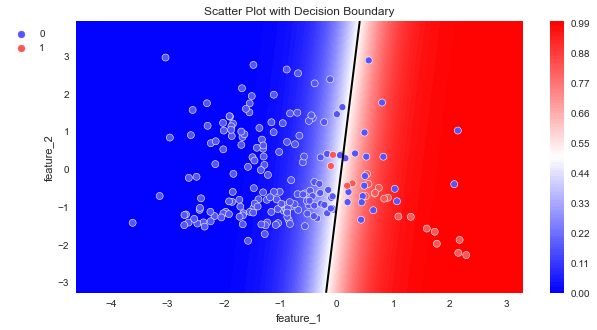

In [38]:
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))
    
plot_probabilities_2d(X, y, log_reg)

# ВЫБОР ПОРОГА ВЕРОЯТНОСТИ. PR-КРИВАЯ

Следующий метод, о котором мы поговорим, — это выбор **порога вероятности (бинаризации)**.

Мы знаем, что любой классификатор предсказывает для объектов вероятности их принадлежности к классу 1 (`P_`) и классу 0 (`Q=1-P_`). Класс объекта по умолчанию определяется по следующему правилу:

* Если вероятность `P_ > 0.5`, то объект относится моделью к `классу 1`.
* Если вероятность `P_ <= 0.5`, то объект относится моделью к `классу 0`.

Однако из модуля по классификации мы также знаем, что данный порог можно поменять и сделать его равным, например, `0.15` или `0.7`. Это является очень распространённой практикой, ведь для каждой задачи может быть свой оптимальный порог вероятности.

Ранее мы уже подбирали оптимальный порог вероятности, строя графики зависимости метрик от порога вручную. Вспомнить, как это было, вы можете в модуле по классификации. В данном модуле мы посмотрим на эту задачу иначе. А поможет нам PR-кривая.

`PR`-кривая (`precision-recall curve`) — это график зависимости `precision` от `recall` при различных значениях порога вероятности.

Для построения данного графика мы берём множество различных порогов вероятности (0.1, 0.15, 0.2, …1) и вычисляем метрики `precision` и `recall` при разных порогах вероятности. Если мы построим линейный график зависимости `precision` от `recall`, то получим примерно следующую картину:

<img src=ml5_img10.png>

# Что нам даёт такая кривая?

1. Во-первых, `PR`-кривая — это графическая метрика качества модели, она комплексно отражает и `precision`, и `recall` одновременно (как `F1`-мера) и особенно хороша в условиях дисбаланса классов.

Качество определяется площадью (`PR AUC`) **под кривой**: чем ближе значение площади к 1, тем лучше модель. Идеальная модель — та, у которой площадь `равна 1`. У такой модели и `precision`, и `recall` равны 1. Конечно же, таких моделей не существует в природе.

Если площадь под `PR`-кривой `меньше 0.5`, модель считается очень слабой (качество её распознавания хуже, чем подбрасывание монетки).

<img src=ml5_img11.png>

Например, ниже изображены `PR`-кривые для логистической регрессии (`Logistic Regression`) и случайного леса (`Random Forest`). Площадь под первой кривой — `0.680`, под второй — `0.688`. Можно сделать вывод, что с небольшим отрывом на тысячных долях побеждает случайный лес.

<img src=ml5_img12.png>

2. Во-вторых, с помощью `PR`-кривой удобно находить оптимальный порог вероятности. Главное — определиться с критерием этой оптимальности. На кривой мы можем найти такие точки, в которых наблюдается наилучшее значение `precision` или `recall` или среднее геометрическое между ними (`F1-score`). 

Подберём порог вероятности с помощью `PR`-кривой для нашего примера. Так как порог вероятности является внешним параметром модели, будет правильнее подбирать его на кросс-валидации, организованной на тренировочном наборе данных, а итоговое качество оценивать на отложенной выборке.

Пусть мы хотим найти такой порог вероятности, при котором наблюдается максимум метрики `F1` для класса 1 (питьевая вода).

Перед построением `PR`-кривой нам необходимо предсказать вероятности принадлежности к классу 1 на валидационных фолдах кросс-валидации.

Для предсказания вероятностей используем функцию [cross_val_predict()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html). Данная функция выполняет кросс-валидацию и возвращает предсказания для валидационных фолдов. Если ей передать параметр `method='predict_proba'`, она вернёт предсказанные вероятности для каждого из классов на всех фолдах. Остальные параметры аналогичны параметрам функции `cross_validate()`.

In [39]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел 
)
#Обучаем модель
model.fit(X_train, y_train)
#Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')

Это массив из вероятностей для каждого образца воды. Первое число в строке — вероятность того, что данный образец является непригодным для питья, а второе — вероятность того, что данный образец пригоден для питья.

Нас интересует класс 1 (пригодная для питья вода). Это второй столбец в матрице вероятностей (индекс 1). Выделим этот столбец из матрицы с вероятностями:

In [40]:
#Выделяем столбец с вероятностями для класса 1 
y_cv_proba_pred = y_cv_proba_pred[:, 1]

Теперь мы можем построить PR-кривую. Для этого воспользуемся функций [precision_recall_curve()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) из модуля `metrics` библиотеки `sklearn`. В данную функцию нужно передать истинные метки классов и предсказанные вероятности. Взамен она вернёт три массива: значения метрик `precision` и `recall`, вычисленных на различных порогах вероятности, и сами пороги вероятности:

In [41]:
#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

print('Thresholds:', thresholds[:5])
print('Precision scores:', precision[:5])
print('Recall scores:',recall[:5])

Thresholds: [0.         0.16666667 0.25       0.28571429 0.5       ]
Precision scores: [0.1        0.48275862 0.5        0.59090909 0.61904762]
Recall scores: [1.     0.875  0.875  0.8125 0.8125]


Осталось дело за малым. Вычислим значение `F1-score` при различных порогах вероятности и найдём такой порог вероятности, при котором она максимальна. Сделать это можно с помощью функции [argmax()](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) из модуля `numpy` — она возвращает индекс максимального элемента массива.

Далее построим PR-кривую и отметим на ней точку максимума `F1-score`.

Best threshold = 0.56, F1-Score = 0.74


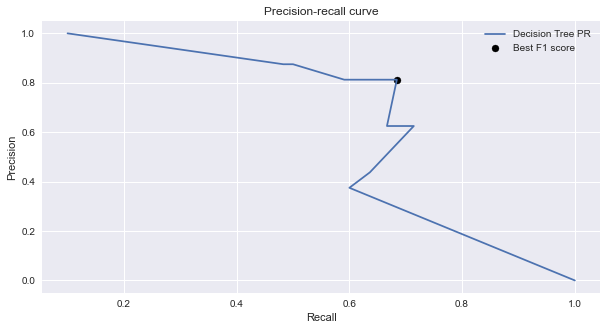

In [42]:
#Вычисляем F1-score при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))
 
#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от recall
ax.plot(precision, recall, label='Decision Tree PR')
#Отмечаем точку максимума F1
ax.scatter(precision[idx], recall[idx], marker='o', color='black', label='Best F1 score')
#Даём графику название и подписываем оси
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();

Итак, согласно нашим вычислениям и построенной PR-кривой, максимум `F1` (0.69) на кросс-валидации наблюдается при пороге вероятности `0.33`.

Сделаем предсказание классов с таким порогом для всех объектов из отложенной валидационной выборки и выведем отчёт о метриках:

In [44]:
#Образцы воды, для которых вероятность быть пригодными для питья > threshold_opt, относим к классу 1
#В противном случае — к классу 0
y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_pred_proba > 0.56).astype('int')
#Считаем метрики
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        36
           1       0.50      0.50      0.50         4

    accuracy                           0.90        40
   macro avg       0.72      0.72      0.72        40
weighted avg       0.90      0.90      0.90        40



In [45]:
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))

PR AUC: 0.66


# СЭМПЛИРОВАНИЕ

Следующий подход работы в условиях дисбаланса классов, который мы рассмотрим, — `сэмплирование`, а точнее — пересэмплирование (`oversampling`).

>Идея очень проста: если у нас мало наблюдений миноритарного класса, следует искусственно увеличить их количество.

<img src=ml5_img13.png>

Простейшая стратегия пересэмплирования — продублировать объекты малого класса. Но это неинтересно и работает довольно плохо. Поэтому были созданы специальные алгоритмы генерации искусственных данных. Самый популярный из таких алгоритмов — алгоритм `SMOTE` (`Synthetic Minority Oversampling Techniques`).

В основе алгоритма лежит идея генерации некоторого количества искусственных наблюдений, которые были бы «похожи» на наблюдения, имеющиеся в миноритарном классе, но при этом не дублировали их.

Мы не будем сейчас заострять внимание на математической работе алгоритма, и вместо этого посмотрим на 2D-анимацию работы данного метода:

<img src=ml5_gif1.gif>

Алгоритмов сэмплирования, в том числе `SMOTE`, нет в стандартном пакете `sklearn` — они содержатся в библиотеке `imblearn` (`imbalanced-learn`). Команды для установки приведены далее.

Для пользователей `pip`:

`!pip install imbalanced-learn`
Для пользователей anaconda:

`!conda install -c conda-forge imbalanced-learn`

Все алгоритмы пересэмплирования находятся в модуле `over_sampling` библиотеки `imblearn`. 

Импортируем оттуда алгоритм SMOTE:

In [46]:
from imblearn.over_sampling import SMOTE

Создадим объект класса `SMOTE` и вызовем у него метод `fit_sample()`, передав в него обучающую выборку `(X_train, y_train)`. Затем выведем количество наблюдений каждого из классов до и после сэмплирования:

In [49]:
sm = SMOTE(random_state=42)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)

print('Train shape before oversampling:', X_train.shape) 
print('Class balance before oversampling: \n', y_train.value_counts(), sep='')
print('-'*40)
print('Train shape after oversampling:', X_train_s.shape)
print('Class balance after oversampling: \n', y_train_s.value_counts(), sep='')

Train shape before oversampling: (160, 2)
Class balance before oversampling: 
0    144
1     16
dtype: int64
----------------------------------------
Train shape after oversampling: (288, 2)
Class balance after oversampling: 
0    144
1    144
dtype: int64


Попробуем обучить нашу модель на сгенерированных обучающих данных и сделать предсказание на валидационной выборке (обратите внимание, что с валидационным набором данных мы не производим никаких преобразований), чтобы рассчитать метрики:

In [48]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке (с сэмплированием)
model.fit(X_train_s, y_train_s)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        36
           1       0.43      0.75      0.55         4

    accuracy                           0.88        40
   macro avg       0.70      0.82      0.74        40
weighted avg       0.92      0.88      0.89        40



In [50]:
log_reg = linear_model.LogisticRegression()
log_reg.fit(X_train_s, y_train_s)
y_train_pred = log_reg.predict(X_train)
y_valid_pred = log_reg.predict(X_valid)
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        36
           1       0.43      0.75      0.55         4

    accuracy                           0.88        40
   macro avg       0.70      0.82      0.74        40
weighted avg       0.92      0.88      0.89        40



c:\Users\AubakirovMA\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\AubakirovMA\AppData\Local\Temp\ipykernel_16980\1900572677.py:23: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colorbar = fig.colorbar(contour)


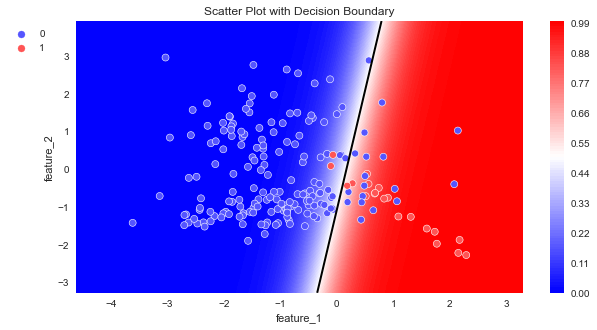

In [51]:
plot_probabilities_2d(X, y, log_reg)

# Полезно помнить: хорошие признаки и правильно подобранная модель — вот что самое главное в ML. Всё остальное — второстепенно.

4. # Недообучение и переобучение. Утечка данных <a class="anchor" id=4></a>

[к содержанию](#0)

Обобщающая способность часто страдает из-за двух основных проблем машинного обучения: `overfitting` (переобучение) и `underfitting` (недообучение).

>Переобучение (`overfitting`) — это проблема, при которой модель чувствительна к незначительным колебаниям в данных в процессе обучения. По сути, такая модель работает намного лучше с обучающими данными, чем с новыми. Она была чрезмерно натренирована на обнаружение уникальных характеристик обучающего набора данных, которые не являются общими закономерностями.

>Недообучение (`underfitting`) — это проблема, при которой алгоритм недостаточно хорошо изучил данные и пропускает важные зависимости между признаками. В случае недообучения мы даже на обучающих данных не можем достичь приемлемых оценок для модели.

>Смещение (`bias`) — это математическое ожидание (обозначено далее как `E`) разности между истинным ответом и ответом, выданным моделью. То есть это ожидаемая ошибка модели.

>Разброс (`variance`) — это вариативность ошибки, то, насколько ошибка будет отличаться, если обучать модель на разных наборах данных. Математически это дисперсия (разброс) ответов модели (обозначено далее как `Var`).

**Для логической регрессии**

<img src=ml5_img14.png>

**Для классификации**

<img src=ml5_img15.png>



# КАК ОБНАРУЖИТЬ ПЕРЕОБУЧЕНИЕ

Основные способы отследить переобучение:

* `hold-out`-разбиение,

* `k-fold`-валидация и `leave-one-out`-валидация,

* кривые обучения (`learning curves`).

Для этого стратифицированно разобьём набор данных на тренировочную и валидационную выборки в соотношении 80/20 и обучим дерево решений с энтропией  в качестве критерия информативности и сбалансированными весами классов без ограничения его глубины и количества объектов в листе. Сделаем предсказание для каждой из выборок и рассчитаем метрику `F1-score`:

In [52]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаём модель
model_bad = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    class_weight='balanced', #веса классов
    random_state=42 #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model_bad.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model_bad.predict(X_train)
y_valid_pred = model_bad.predict(X_valid)
#Выводим значения метрик для тренировочной выборки
print('Train F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
#Выводим значения метрик для валидационной выборки
print('Valid F1 score: {:.2f}'.format(metrics.f1_score(y_valid, y_valid_pred)))

Train F1 score: 1.00
Valid F1 score: 0.60


* Значение `F1-score` на тренировочной выборке показывает, что задача классификации образцов воды на пригодные и непригодные для питья решена идеально. Метрика равна максимуму — 1, а значит, и `precision` и `recall` для каждого из классов равны 1 (значит, и значения всех остальных метрик тоже максимальны). То есть модель правильно определила класс для всех образцов воды из набора данных.

* Однако значение `F1-score`, полученное на валидационной выборке, менее оптимистично. Значение метрики на контроле значительно ниже, чем при обучении.

Это типичная картина переобучения: модель дерева решений полностью адаптировалась под обучающий набор данных, но не нашла общих закономерностей, поэтому результаты на контроле оставляют желать лучшего.

Проверим гипотезу о наличии переобучения у нашего дерева с помощью кросс-валидации `k-fold`. Организуем стратифицированную кросс-валидацию на пяти фолдах. На каждом шаге кросс-валидации будем вычислять метрику  на тренировочных и валидационных фолдах.

In [53]:
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model_bad, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.00398922, 0.00199437, 0.00199556, 0.00199342, 0.0019958 ]),
 'score_time': array([0.00199604, 0.00199485, 0.00199485, 0.00099778, 0.00202537]),
 'test_score': array([0.8       , 0.85714286, 0.75      , 0.57142857, 0.88888889]),
 'train_score': array([1., 1., 1., 1., 1.])}

Подсчитаем среднее значение `F1-score` на выборках:

In [54]:
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 1.00
Valid k-fold mean f1: 0.77


Ниже представлен код для генерации задачи классификации и отрисовки диаграммы рассеяния с цветовой группировкой по классам.

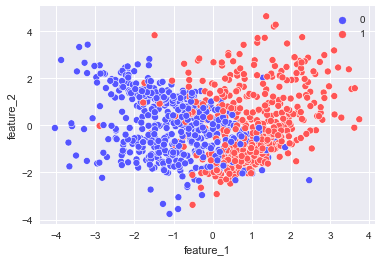

In [57]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=1000, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    n_clusters_per_class=2, #количество кластеров внутри класса
    random_state=1 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y, palette='seismic');

Разделите исходный набор данных на тренировочную и валидационную выборки в соотношении `70/30`, используя функцию `train_test_split()`. В качестве значения параметра `random_state` возьмите число `42`.

Обучите модель дерева решений с глубиной 10 (остальные параметры оставьте по умолчанию) для решения задачи классификации на тренировочной выборке. Сделайте предсказания для тренировочной и валидационной выборок и рассчитайте метрику accuracy.

В качестве ответа укажите значение метрики `accuracy` на тренировочной и валидационной выборках. Ответ округлите до двух знаков после точки-разделителя.

In [65]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)
#Создаём модель
model_1 = tree.DecisionTreeClassifier(
    max_depth=10
)
#Обучаем модель на тренировочной выборке
model_1.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model_1.predict(X_train)
y_valid_pred = model_1.predict(X_valid)
#Выводим значения метрик для тренировочной выборки
print('Train Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
#Выводим значения метрик для валидационной выборки
print('Valid Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred)))

Train Accuracy score: 0.98
Valid Accuracy score: 0.82


c:\Users\AubakirovMA\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\AubakirovMA\AppData\Local\Temp\ipykernel_16980\1900572677.py:23: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colorbar = fig.colorbar(contour)


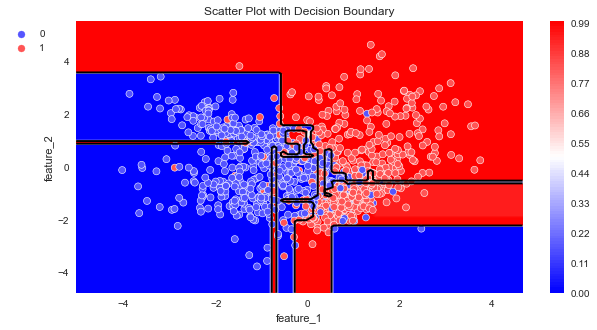

In [66]:
plot_probabilities_2d(X, y, model_1)

# МЕТОДЫ БОРЬБЫ С ПЕРЕОБУЧЕНИЕМ

Мы посмотрели как с помощью методов валидации можно определить наличие переобучения. Но как с ним бороться?

Существует несколько основных способов, и с каждым из них мы уже знакомились в нашем курсе. Ключевая идея, заложенная в каждом из методов, звучит так: **снизить переобучение = уменьшить разброс (вариативность) ошибки модели**:

## 1. УМЕНЬШЕНИЕ СЛОЖНОСТИ МОДЕЛИ

Это основной способ борьбы с переобучением, так как, по сути, повышенная сложность модели и является его причиной.

* Для линейной (логистической) регрессии с полиномиальными признаками уменьшение сложности модели означает понижение степени полинома.

* Для деревьев решений — «стрижка» (`pruning`) деревьев, то есть уменьшение их глубины (`max_depth`) и/или увеличение количества объектов, при которых вершина дерева превращается в лист (`min_samples_leaf`).

* Для случайного леса — «стрижка» деревьев (`max_depth` и `min_samples_leaf`) и уменьшение количества признаков, на которых обучается каждое дерево (`max_features`).

## 2. РЕГУЛЯРИЗАЦИЯ

С помощью добавления штрафа в функцию потерь мы намеренно пытаемся увеличить смещение модели, чтобы уменьшить разброс. Закон баланса в действии!

Ранее мы изучали регуляризацию только в контексте линейных моделей, но на самом деле она есть и во многих других методах машинного обучения, с которыми мы будем знакомиться в дальнейшем.

На рисунке ниже приведено несколько примеров одной и той же модели — полинома восьмой степени с различными коэффициентами регуляризации (обозначен как `lambda`). Видно, что чем выше `lambda`, тем меньше переобучение. Однако есть риск увеличить `lambda`  слишком сильно, и тогда модель превратится в недообученную (левый нижний рисунок).

<img src=ml5_img16.png>

## 3. МАНИПУЛЯЦИИ С ДАННЫМИ

Ещё один верный способ побороть переобучение — увеличить или уменьшить количество примеров, на которых обучается модель.

* Увеличивать набор данных можно за счёт проведения новых экспериментов и сбора новой информации.

* Уменьшать набор данных можно за счёт удаления выбросов и аномалий из обучающего набора данных, из-за которых отчасти и происходит переобучение модели.

Также можно отбирать наиболее значимые признаки, которые в наибольшей степени влияют на предсказания модели.

О применении метода работы с данными мы поговорим в следующем модуле.

In [67]:
print('Current depth:', model_bad.get_depth())

Current depth: 7


In [68]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #ограничиваем глубину дерева
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 0.92
Valid k-fold mean f1: 0.84


Напомним интерпретацию данного параметра. Пусть `min_samples_leaf=5`. Допустим, в результате разделения получается две вершины: первая — с четырьмя объектами, а вторая — с шестью. Тогда дерево разрешит снова делиться только второй вершине (`6 > min_samples_leaf`), а первая вершина (`4 < min_samples_leaf`) дерева превратится в лист, и её деление будет остановлено.

In [69]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #ограничиваем глубину дерева
    min_samples_leaf=5, #увеличиваем количество объектов в листе
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 0.91
Valid k-fold mean f1: 0.85


Нам удалось ещё немного сократить разницу между метриками на тренировочных и валидационных фолдах и уменьшить переобучение.

**Примечание**. В приведённом выше примере мы выбирали параметры исключительно по принципу «холодно-горячо». Конечно же, в реальности никто так не делает — существуют специальные механизмы перебора комбинаций внешних параметров модели, и мы познакомимся с ними в отдельном модуле.

In [70]:
# 4.3
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=1000, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    n_clusters_per_class=2, #количество кластеров внутри класса
    random_state=1 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)


In [71]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)
#Создаём модель
model_1 = tree.DecisionTreeClassifier(
    max_depth=3
)
#Обучаем модель на тренировочной выборке
model_1.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model_1.predict(X_train)
y_valid_pred = model_1.predict(X_valid)
#Выводим значения метрик для тренировочной выборки
print('Train Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
#Выводим значения метрик для валидационной выборки
print('Valid Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred)))

Train Accuracy score: 0.88
Valid Accuracy score: 0.85


c:\Users\AubakirovMA\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\AubakirovMA\AppData\Local\Temp\ipykernel_16980\1900572677.py:23: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colorbar = fig.colorbar(contour)


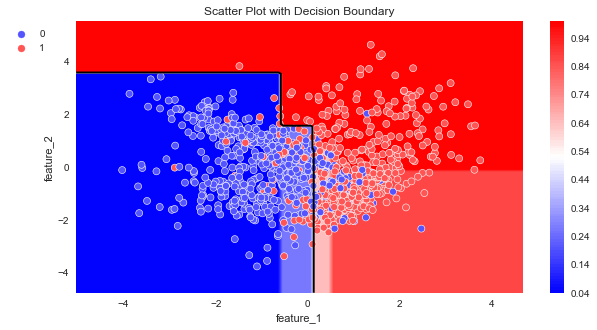

In [72]:
plot_probabilities_2d(X, y, model_1)

# УТЕЧКА ДАННЫХ

Стоит упомянуть об ещё одной проблеме современного машинного обучения, которая называется утечкой данных. Данная проблема несколько похожа на проблему переобучения, но имеет другой характер.

**Утечка данных** (`data leak`) — это ситуация, в которой данные, используемые для обучения модели, содержат прямую или косвенную информацию о целевой переменной.

Приведём несколько примеров, когда может возникнуть утечка данных:

## ОЧЕВИДНЫЕ СЛУЧАИ

* Наиболее очевидной ситуацией утечки данных является включение целевой переменной, которую мы пытаемся предсказать, в качестве фактора, что полностью уничтожает цель «прогнозирования». Это может быть сделано по ошибке, но важно убедиться, что целевая переменная отличается от признаков.

* Другой распространённой причиной утечки данных является включение тестовых данных в данные по обучению модели, а затем использование этих же тестовых данных для оценки качества модели.

Два этих случая возникают скорее по невнимательности, и их легко обнаружить. Более опасные причины — скрытые.

## СКРЫТЫЕ СЛУЧАИ, ИЛИ `GIVEAWAY`-ПРИЗНАКИ

`Giveaway` — это признаки, которые раскрывают информацию о целевой переменной и не будут доступны после развёртывания модели в реальных условиях. Такие признаки необходимо удалять из данных перед построением модели.

* **Пример № 1**

Мы строим модель для прогнозирования определённого состояния здоровья человека. У нас есть признак, который указывает на то, была ли у пациента операция, связанная с тем же заболеванием, которое мы предсказываем.

Указание на хирургическое вмешательство в высокой степени предсказывает состояние здоровья, и, вероятно, эта информация будет доступна далеко не всегда (в основном в случаях рецидива).

Если мы уже знаем, что пациент перенёс операцию, что могло сказаться на состоянии здоровья, нам может даже не понадобиться прогнозирующая модель.

* **Пример № 2**

Мы прогнозируем, продолжит ли юзер пользоваться нашим приложением после какой-то определённой даты.

Включение признаков, предоставляющих информацию о будущих посещениях приложения, опять же приведёт к утечке данных.

Мы должны использовать только признаки, описывающие предыдущие сеансы, так как информация о будущих сеансах будет недоступна после развёртывания модели.

# КАК ОБНАРУЖИТЬ УТЕЧКУ ДАННЫХ

Читайте описание признаков.

Из описания признаков всегда можно узнать полезную информацию и обнаружить утечку с помощью банальной логики. Если вы предсказываете цену товара, а в вашем наборе данных есть признак цены этого товара со скидкой, очевидно, что данный признак стоит удалить из обучающего набора данных.

Проверяйте корреляции с целевым признаком.

В процессе разведывательного анализа вы можете обнаружить признаки, которые очень сильно коррелируют с целевой переменной. Конечно, такая корреляция может быть естественной и не сопровождаться утечкой, например корреляция между количеством комнат в квартире и её ценой. Однако высокая степень корреляции между налоговой выплатой за продажу и ценой квартиры — это яркий пример утечки.

Относитесь скептически к подозрительно высокому качеству моделей.

При построении модели вас может насторожить слишком высокое качество даже самых простых моделей, которого в реальных условиях достичь не удалось бы. Это может быть сигналом о наличии утечки данных.

Поэтому для начала старайтесь строить baseline — простые модели машинного обучения, такие как логистическая регрессия.

5. # Валидация данных. Методы валидации <a class="anchor" id=5></a>

[к содержанию](#0)

6. # Практика <a class="anchor" id=6></a>

[к содержанию](#0)

7. # Итоги <a class="anchor" id=7></a>

[к содержанию](#0)